In [1]:
# toc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.api.models import Model
from keras.api.layers import Input, Dense
from keras.api.optimizers import Adam

plt.style.use('../maroon_ipynb.mplstyle')
tf.config.set_visible_devices([], 'GPU')

# Problem 1
A function $u(x, y)$ is defined on a unit square $x \in [0, 1]$, $y \in [0, 1]$, and obeys the following partial differential equation:

$$\nabla^2u(x, y) = e^{-x}\left(x - a + y^3 + by\right)$$

Where $a$ and $b$ are constants. The function $u(x, y)$ is also subject to the following Dirichlet boundary conditions:

$$
\begin{gathered}
u(0, y) = y^3 \\
u(1, y) = (1 + y^3)/e \\
u(x, 0) = xe^{-x} \\
u(x, 1) = e^{-x}(1 + x)
\end{gathered}
$$

For particular values of $a$ and $b$ the analytic solution is:

$$u(x, y) = e^{-x}(x + y^3)$$

Construct a physics-informed neural network (PINN) to determine the unknown constants $a$ and $b$ which give this solution. Try to minimize the number of points away from the boundary which explicitly use the analytic solution. Plot how the prediction of $a$ and $b$ evolves with the number of training epochs.

## Solution
To solve this problem, we need to determine the unknown constants $a$ and $b$ in a partial differential equation (PDE) using a Physics-Informed Neural Network (PINN). The solution involves training a neural network to approximate the function
$u(x,y)$ while satisfying the given boundary conditions and the PDE, which includes the constants $a$ and $b$. These constants are treated as trainable variables in the model.

### Generate Boundary and Collocation Points
Boundary points are sampled from the edges of the unit square, and their corresponding $u$ values are computed using the given Dirichlet boundary conditions. Collocation points are randomly sampled from the interior of the unit square to enforce the PDE constraint.

In [2]:
# Define some constant sizes
N_b = 100  # number of points per edge
N_f = 1000  # number of collocation points

# For x=0
x_b1 = np.zeros((N_b, 1))
y_b1 = np.linspace(0, 1, N_b).reshape(-1, 1)
u_b1 = y_b1**3

# For x=1
x_b2 = np.ones((N_b, 1))
y_b2 = np.linspace(0, 1, N_b).reshape(-1, 1)
u_b2 = (1 + y_b2**3)/np.exp(1)

# For y=0
x_b3 = np.linspace(0, 1, N_b).reshape(-1, 1)
y_b3 = np.zeros((N_b, 1))
u_b3 = x_b3*np.exp(-x_b3)

# For y=1
x_b4 = np.linspace(0, 1, N_b).reshape(-1, 1)
y_b4 = np.ones((N_b, 1))
u_b4 = np.exp(-x_b4)*(1 + x_b4)

# Combine all boundary points
X_bc = np.vstack([
    np.hstack([x_b1, y_b1]),
    np.hstack([x_b2, y_b2]),
    np.hstack([x_b3, y_b3]),
    np.hstack([x_b4, y_b4])
])
u_bc = np.vstack([u_b1, u_b2, u_b3, u_b4])

# Generate collocation points
x_f = np.random.rand(N_f, 1)
y_f = np.random.rand(N_f, 1)
X_pde = np.hstack([x_f, y_f])

# Convert to TensorFlow tensors
X_bc_tf = tf.convert_to_tensor(X_bc, dtype=tf.float32)
u_bc_tf = tf.convert_to_tensor(u_bc, dtype=tf.float32)
X_pde_tf = tf.convert_to_tensor(X_pde, dtype=tf.float32)

### Build the PINN Model

In [3]:
def create_model():
    inputs = Input(shape=(2,))
    x = Dense(64, activation='tanh')(inputs)
    x = Dense(64, activation='tanh')(x)
    x = Dense(64, activation='tanh')(x)
    outputs = Dense(1)(x)
    model_ = Model(inputs=inputs, outputs=outputs)
    return model_


model = create_model()

# Initialize trainable variables a and b
a = tf.Variable(1.5, dtype=tf.float32, name='a')
b = tf.Variable(6.5, dtype=tf.float32, name='b')

# Define the optimizer
optimizer = Adam(learning_rate=0.005)

### Training Step
The total loss (sum of boundary and PDE losses) is minimized using the Adam optimizer. The gradients of the total loss with respect to the network's parameters and the constants $a$ and $b$ are computed and used to update these variables.

In [4]:
pde_loss_weight = 1  # weight to emphasize PDE constraint

@tf.function
def train_step(X_bc_, u_bc_, X_pde_):
    with tf.GradientTape() as tape:
        # BC loss
        u_pred_bc = model(X_bc_, training=True)
        bc_loss_ = tf.reduce_mean((u_bc_ - u_pred_bc)**2)

        # PDE loss (as before) …
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(X_pde_)
            u_pred_pde = model(X_pde_, training=True)
            grad_u = tape2.gradient(u_pred_pde, X_pde_)
            u_x = grad_u[:, 0:1]
            u_y = grad_u[:, 1:2]
        u_xx = tape2.gradient(u_x, X_pde_)[:, 0:1]
        u_yy = tape2.gradient(u_y, X_pde_)[:, 1:2]
        del tape2

        x_pde = X_pde_[:, 0:1]
        y_pde = X_pde_[:, 1:2]
        rhs = tf.exp(-x_pde)*(x_pde - a + y_pde**3 + b*y_pde)
        PDE_resid = u_xx + u_yy - rhs
        pde_loss_ = tf.reduce_mean(PDE_resid**2)

        total_loss_ = bc_loss_ + pde_loss_weight*pde_loss_

    grads = tape.gradient(total_loss_, model.trainable_variables + [a, b])
    optimizer.apply_gradients(zip(grads, model.trainable_variables + [a, b]))
    return bc_loss_, pde_loss_, total_loss_

Now we can finish training and tracking the values of $a$ and $b$.

Epoch   500  |  BC_loss = 4.528e-04  PDE_loss = 4.010e-04 a = 1.5998  b = 6.3810
Epoch  1000  |  BC_loss = 1.602e-04  PDE_loss = 9.751e-05 a = 1.6051  b = 6.3740
Epoch  1500  |  BC_loss = 9.363e-05  PDE_loss = 5.798e-05 a = 1.6119  b = 6.3644
Epoch  2000  |  BC_loss = 1.209e-04  PDE_loss = 3.179e-05 a = 1.6205  b = 6.3500
Epoch  2500  |  BC_loss = 4.884e-04  PDE_loss = 4.162e-04 a = 1.6275  b = 6.3390
Epoch  3000  |  BC_loss = 1.670e-04  PDE_loss = 1.066e-03 a = 1.6357  b = 6.3259
Epoch  3500  |  BC_loss = 1.717e-04  PDE_loss = 2.056e-04 a = 1.6450  b = 6.3097
Epoch  4000  |  BC_loss = 1.269e-04  PDE_loss = 6.969e-05 a = 1.6529  b = 6.2923
Epoch  4500  |  BC_loss = 5.008e-04  PDE_loss = 4.085e-04 a = 1.6631  b = 6.2711
Epoch  5000  |  BC_loss = 1.478e-04  PDE_loss = 1.140e-03 a = 1.6666  b = 6.2662
Epoch  5500  |  BC_loss = 4.289e-05  PDE_loss = 1.591e-05 a = 1.6732  b = 6.2501
Epoch  6000  |  BC_loss = 2.866e-04  PDE_loss = 6.171e-04 a = 1.6794  b = 6.2373
Epoch  6500  |  BC_loss = 6.

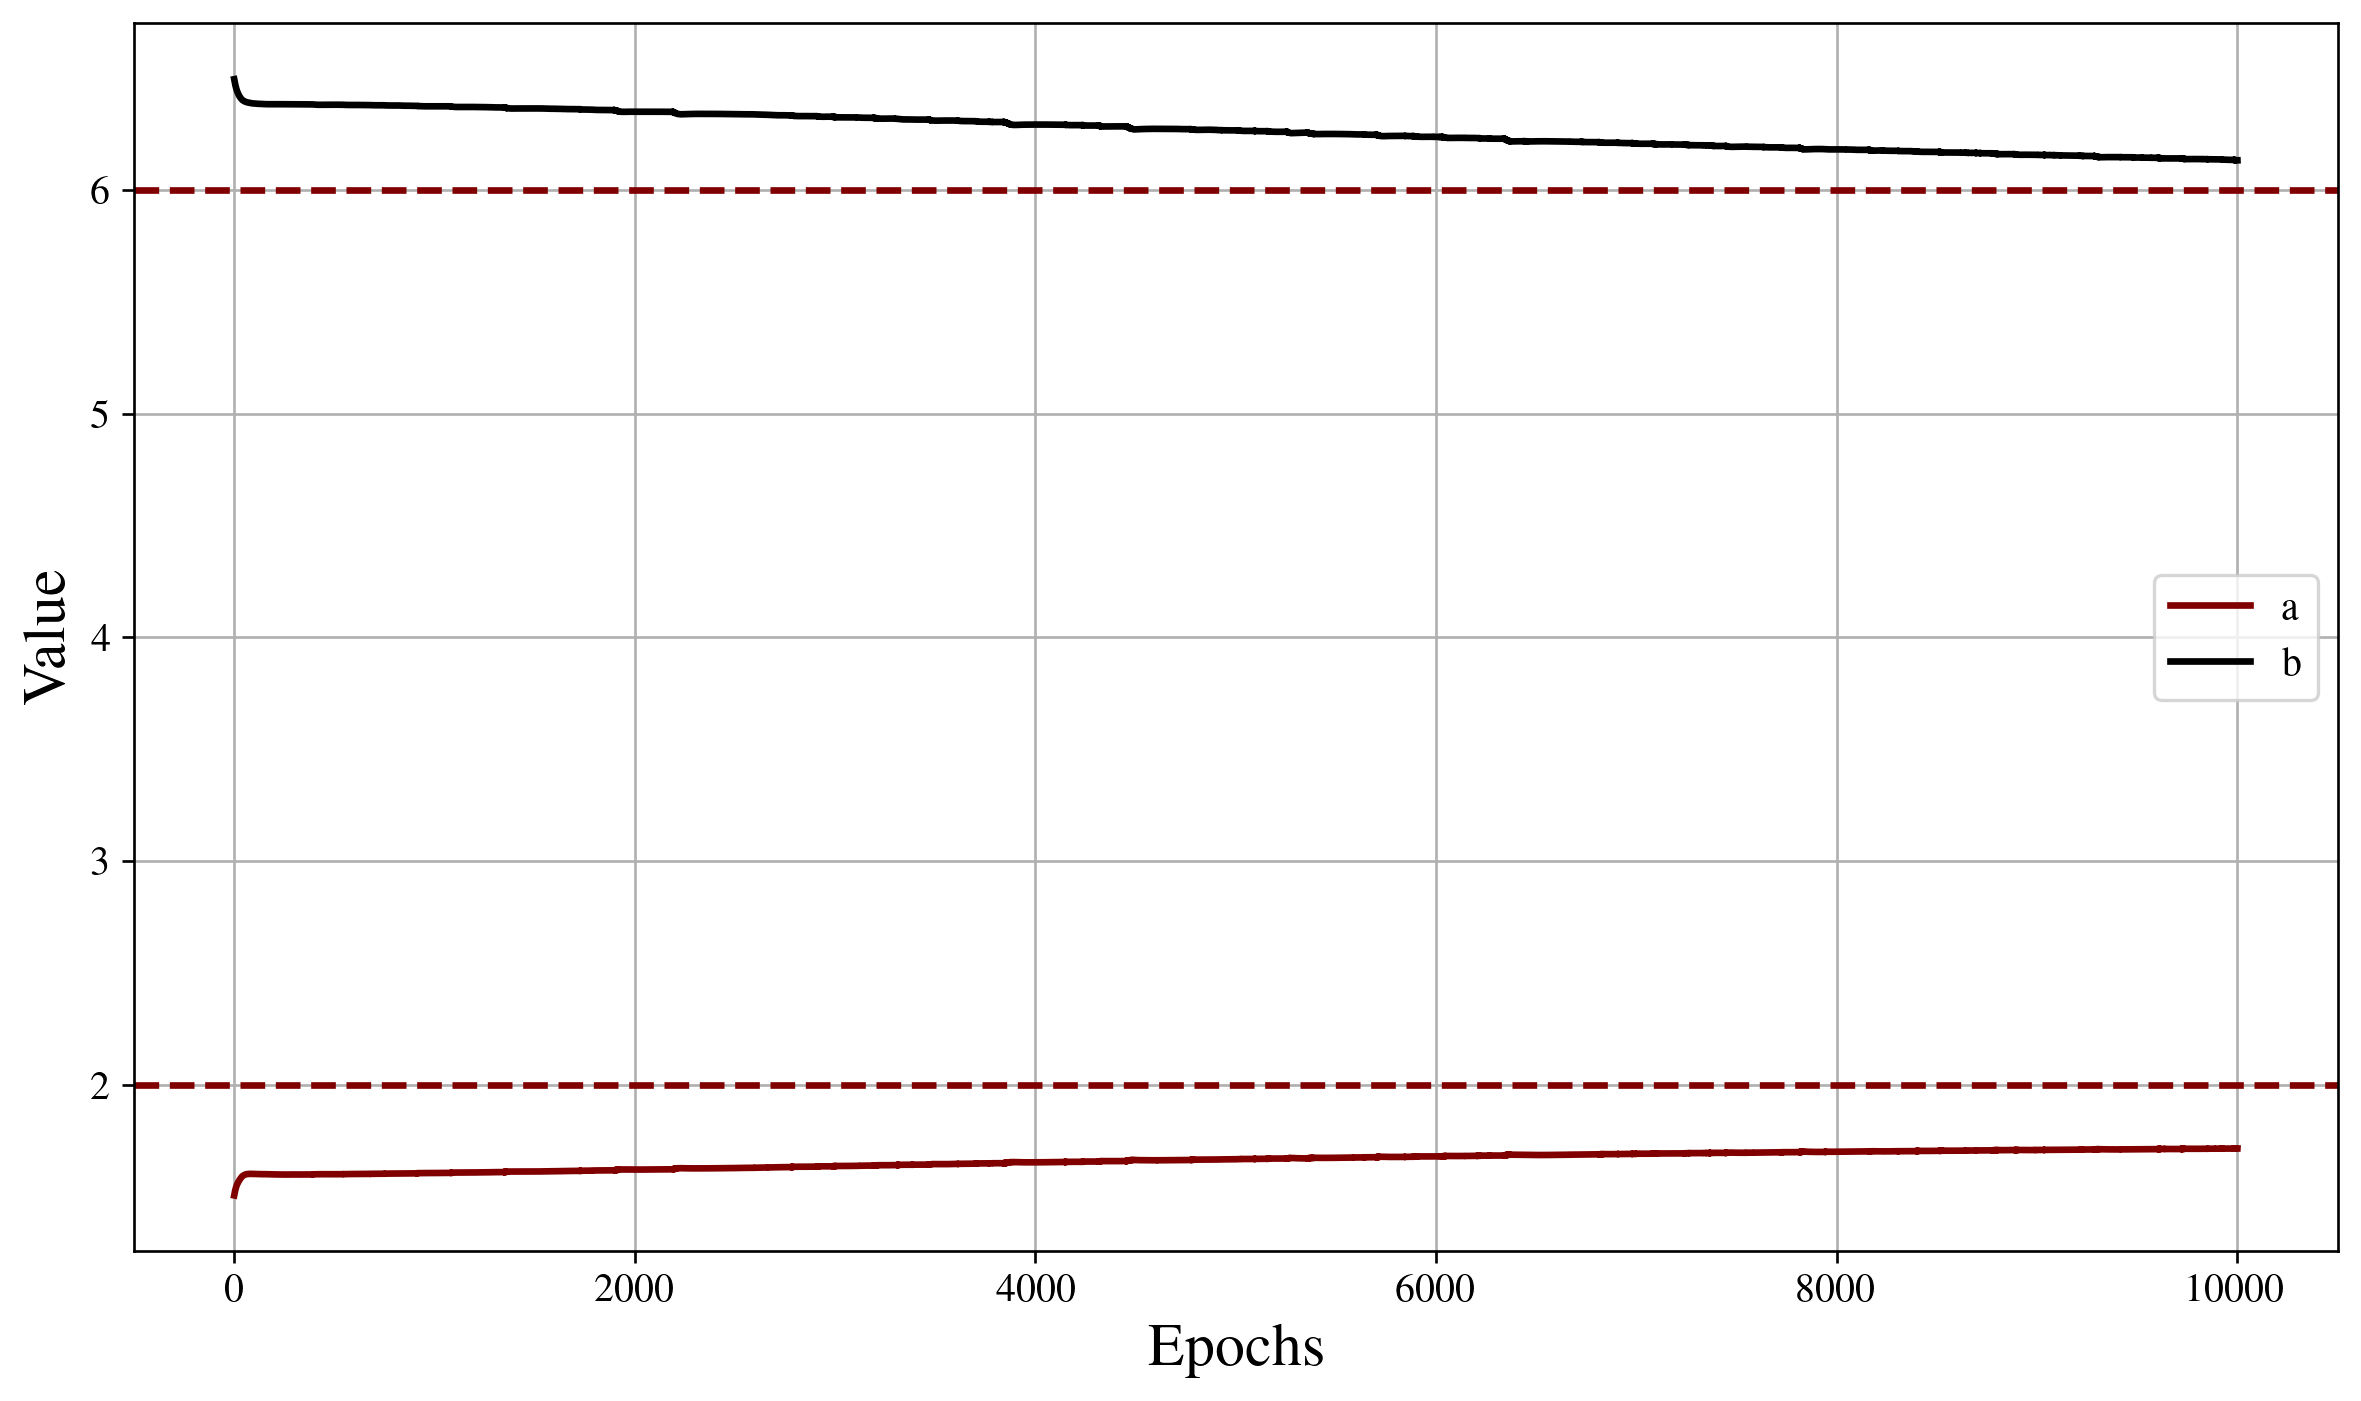

In [5]:
epochs = 10_000
a_history, b_history = [], []
loss_history = []

for epoch in range(1, epochs + 1):
    # Resample interior
    x_f = np.random.rand(N_f, 1)
    y_f = np.random.rand(N_f, 1)
    X_pde_tf = tf.convert_to_tensor(np.hstack([x_f, y_f]), dtype=tf.float32)

    bc_loss, pde_loss, total_loss = train_step(X_bc_tf, u_bc_tf, X_pde_tf)
    a_history.append(a.numpy())
    b_history.append(b.numpy())

    if epoch%500 == 0:
        print(f"Epoch {epoch:5d}  |  BC_loss = {bc_loss:.3e}  PDE_loss = {pde_loss:.3e} a = {a.numpy():.4f}  b = {b.numpy():.4f}")

epoch_array = np.arange(1, epochs + 1)
plt.plot(epoch_array, a_history, label='a')
plt.plot(epoch_array, b_history, label='b')
plt.axhline(y=2, ls='--', color='darkgrey')
plt.axhline(y=6, ls='--', color='darkgrey')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()